In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Linear Regression

In a linear regression with $n$ features and $m$ training samples,
we minimize the **cost function**:

$$J(\theta) = \frac{1}{2 m}\sum_{i=1}^m \left( h_\theta(x^{(i)}) - y^{(i)} \right)^2$$

The hypothesis (or model) is:

$$h_\theta(x) = \theta^T x = \sum_{j=0}^n \theta_j x_j = \theta_0 + \theta_1 x_1 + ... + \theta_n x_n$$

$x_0$ is conventionally set to 1 to represent the constant value (also called bias) in the liner combination.

\begin{align}
\frac{\partial}{\partial \theta_j} J(\theta) 
&= \frac{1}{m} \sum_{i=1}^m \left( h_\theta(x^{(i)}) - y^{(i)} \right)\, x_j^{(i)} \\
&= \frac{1}{m} X^T \left( X\,\theta - y \right)
\end{align}

## Gradient Descent: update formula

In gradient descent, at each iteration, we update $\theta$ according to:

$$\theta_j := \theta_j - \alpha \frac{\partial}{\partial \theta_j} J(\theta)$$

for all $j$ at the same time. We repeat until we converge or we reach
the max allowed iterations.

Replacing the partial derivative for $J(\theta)$, we obtain the update formula for the linear regression
in vector form:

$$\theta := \theta - \frac{\alpha}{m} 
$$



## Normal equation

The linear regression can be also solved in closed form with the  **normal equation**:

$$\theta = (X^T X)^{-1} X^T y $$

**Pro:**

- does not require feature rescaling

**Contra:**

- due to matrix inversion, it becomes slower vs Gradient Descent with >~10000 points

## Regularization

Ridge ($L^2$) regularization:

$$J(\theta) = \frac{1}{2 m}\sum_{i=1}^m \left( h_\theta(x^{(i)}) - y^{(i)} \right)^2
+ \frac{\lambda}{2 n} \sum_{k=1}^n\theta_k^2$$

\begin{align}
\frac{\partial}{\partial \theta_j} J(\theta) 
&= \frac{1}{m} \sum_{i=1}^m \left( h_\theta(x^{(i)}) - y^{(i)} \right)\, x_j^{(i)} 
   +\frac{\lambda}{n} \theta_j\\
&= \frac{1}{m} X^T \left( X\,\theta - y \right) +\frac{\lambda}{n} \Theta
\end{align}


# Load Data

Load data in a nicely formatted DataFrame:

In [2]:
df = (pd.read_csv('machine-learning-ex1/ex1/ex1data2.txt', header=None)
      .rename(columns={0: 'size_sqft', 1: 'bedrooms', 2: 'price'})
      .rename_axis('sample', axis='index')
      .rename_axis('feature', axis='columns')
     )
df_orig = df.copy()
df.head()

feature,size_sqft,bedrooms,price
sample,,,
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


In [3]:
df.dtypes

feature
size_sqft    int64
bedrooms     int64
price        int64
dtype: object

# Explore data

First step is always explore the data. This step is missing from Andrw Ng class,
most probably for time constraints. Student simply trust him that the provided
data can be reasonably fitted with linear regression.

But let's take a look. In python seaborn comes to the rescue, but first we need
tidy data:

In [4]:
df_tidy = df.melt(id_vars='price')
df_tidy.sample(5)

,price,feature,value
32,314900,size_sqft,2040
63,299900,bedrooms,2
27,469000,size_sqft,2526
16,299900,size_sqft,1320
73,464500,bedrooms,3


## Features vs target

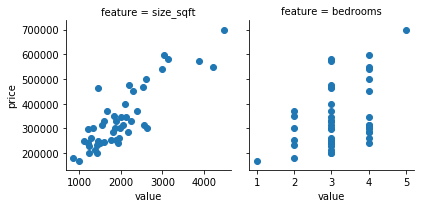

In [5]:
g = sns.FacetGrid(df_tidy, col="feature", sharex=False)
g.map(plt.scatter, "value", "price");

## Pairplot of all features and output variable

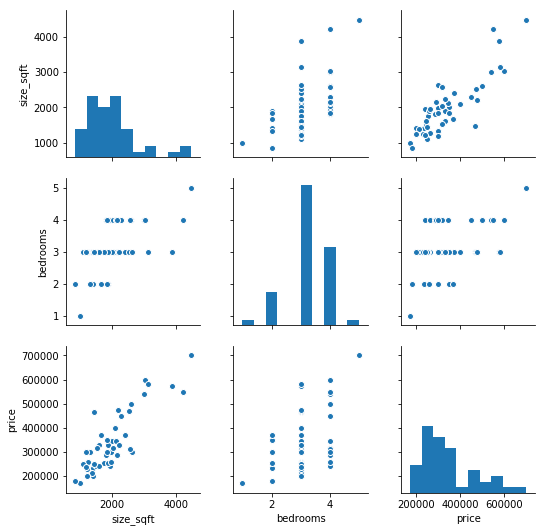

In [6]:
sns.pairplot(df);

# Linear regression

It is nice to have DataFrames, but for the underlying number crunching we use numpy.
Here we get the variables we need for linear regression as numpy arrays:

In [7]:
X = df[['size_sqft', 'bedrooms']].values  # features for each sample
#X = df[['size_sqft']].values             # 1-feature dataset
y = df['price'].values                    # target to be predicted
n = X.shape[1]                            # number of features
n

2

In [8]:
X.shape

(47, 2)

# Normalize features

Normalization helps speeding up Gradient Descent convergence.
When different features have very different scales, their gradient will be very
different too, so progress toward the minimum can happen at very different 
rates in each direction or some direction can exhibit oscillations.

In [9]:
μ, σ = X.mean(0), X.std(0)
μ, σ

(array([2000.68085106,    3.17021277]),
 array([7.86202619e+02, 7.52842809e-01]))

In [10]:
X_norm = (X - X.mean(0)) / X.std(0)
X_norm[:5]

array([[ 0.13141542, -0.22609337],
       [-0.5096407 , -0.22609337],
       [ 0.5079087 , -0.22609337],
       [-0.74367706, -1.5543919 ],
       [ 1.27107075,  1.10220517]])

# Add 0-order feature

The predicted variable is a linear combination of the input features.
It is useful to a constant to the linear combination. 
A numerical trick to do that is
adding an additional "feature" with constant value of 1 across all samples.

In [11]:
X_norm0 = np.hstack([np.ones((X_norm.shape[0], 1)), X_norm])
X_norm0[:5]

array([[ 1.        ,  0.13141542, -0.22609337],
       [ 1.        , -0.5096407 , -0.22609337],
       [ 1.        ,  0.5079087 , -0.22609337],
       [ 1.        , -0.74367706, -1.5543919 ],
       [ 1.        ,  1.27107075,  1.10220517]])

# Functions for Gradient Descent

In [12]:
def _sanitize(X, y, θ):
    θ = np.squeeze(np.asfarray(θ))
    y = np.squeeze(y)
    X = np.atleast_2d(X)
    msg = (f'Incompatible shapes:\n'
           f'X.shape = {X.shape} should be equal to '
           f'(len(y), len(θ)) = {(len(y), len(θ))}')
    assert X.shape == (len(y), len(θ)), msg
    return X, y, θ

def computeCost(X, y, θ):
    """
    Compute the cost function for linear regression.
    
    Arguments:
        X (2D array): array of training sample, one row per sample, one 
            column per feature.
        y (1D array): target variable, same size as the rows in X.
        θ (1D array): model parameters used to compute the cost function
    
    Returns:
        J (float): the cost function computed at θ.
    """
    X, y, θ = _sanitize(X, y, θ)
    m = len(y)  # number of training samples
    error = (X @ θ).T - y
    J = (1 / (2 * m)) * (error @ error)
    return J

def gradientDescent(X, y, θ, α, num_iters):
    """
    Perform Gradient descent to learn θ
    
    Arguments:
        X (2D array): array of training sample, one row per sample, one 
            column per feature.
        y (1D array): target variable, same size as the rows in X.
        θ (1D array): initial parameters, same size as the columns in X.
        num_iter (int): number of iterations for Gradient Descent
    
    Returns:
        A tuple:
        - θ (1D array): the learned/fitted parameters
        - J_history (1D array): the value of the cost function at each iteration
    """
    X, y, θ = _sanitize(X, y, θ)
    
    m = len(y)  # number of training samples
    J_history = np.zeros(num_iters)
    θ_history = np.zeros((num_iters, len(θ)))

    for i in range(num_iters):
        h_θ = X @ θ
        θ = θ - (α / m) * ((h_θ - y) @ X)      
        
        # Save the cost J in every iteration    
        J_history[i] = computeCost(X, y, θ)
        θ_history[i] = θ

    return θ, J_history, θ_history

# Run Gradient Descent

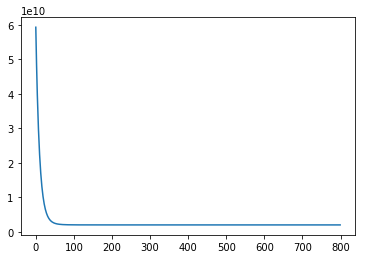

In [13]:
α = 0.05
num_iters = 800

θ = [1, 2, 3]
θ, J_history, θ_history = gradientDescent(X_norm0, y, θ, α, num_iters);
plt.plot(J_history);

In [14]:
θ

array([340412.65957447, 109447.79538813,  -6578.35377265])

# Predict

Predict price of a 1650 sqr-ft apartment with 3 bedrooms:

In [15]:
X.mean(0), X.std(0)

(array([2000.68085106,    3.17021277]),
 array([7.86202619e+02, 7.52842809e-01]))

In [16]:
x_input = np.array([1650, 3])
x = (x_input - X.mean(0)) / X.std(0)
x = np.hstack([1, x])

In [17]:
price = x @ θ
print(f'The price of a {x_input[0]} sq.ft. apartment '
      f'with {x_input[1]} bedrooms is ${price:,.0f}')

The price of a 1650 sq.ft. apartment with 3 bedrooms is $293,081


# Visualize results

We start putting the prediction and error for all the samples in the training set in the DataFrame with all the data, then we tranform it to
tidy using `price`, `price_predicted` and `error` as "id" in the 
wide-to-long transformation:

In [18]:
df = df_orig.copy()

In [19]:
df['price_predicted'] = X_norm0 @ θ
df['error'] = df.price - df.price_predicted

df_tidy = (df
           .melt(id_vars=['price', 'price_predicted', 'error'])
           .sort_values(by='value')
          )
df_tidy.sample(5)

,price,price_predicted,error,feature,value
55,212000,255494.582959,-43494.582959,bedrooms,3
45,299900,312464.002771,-12564.002771,size_sqft,1852
49,369000,397489.469054,-28489.469054,bedrooms,3
26,464500,266353.015426,198146.984574,size_sqft,1458
14,259900,239902.987624,19997.012376,size_sqft,1268


## Error

Error is the different between model and experimental outputs:

(5.207727960449584e-10, 64617.32247838304)

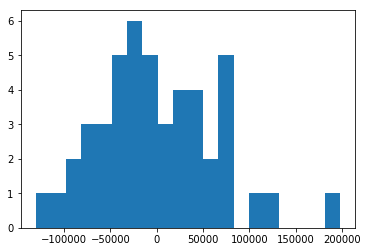

In [20]:
plt.hist(df.error, bins=20)
df.error.mean(), df.error.std()

If the model has low bias the error mean is close to 0.
The error variance will tell us the precision with which we can
estimate the output.

## Features vs output

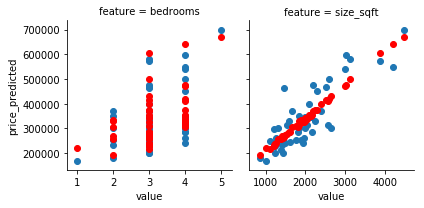

In [21]:
g = sns.FacetGrid(df_tidy, col="feature", sharex=False)
g.map(plt.scatter, "value", "price");
g.map(plt.scatter, "value", "price_predicted", color='r');

We see that the `size_sqft` feature is highly predictive,
while the number of room is much less so.

The output vs `size_sqft` is almost a line, meaning that the
fitting plane has a negligible slope in the `bedroom` direction.

We can better visualize the effect in the next plot:

In [22]:
X.shape

(47, 2)

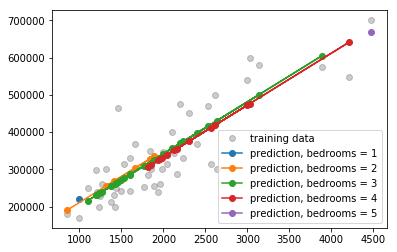

In [23]:
plt.plot(X[:, 0], y, 'ok', alpha=0.2, label='training data')
for bd in range(1, 6):
    mask = X[:, 1] == bd
    plt.plot(X[mask, 0], df.price_predicted[mask], '-o', 
             label=f'prediction, bedrooms = {bd}')
plt.legend();

We see that the difference in number of bedroom is almost negligible.
And it is also negligible compared to the variance of the error.
In essence we can remove the `bedroom` feature without compromising
the accuracy of the prediction.

Note also that the coefficient for `bedroom` is negative:


In [24]:
θ

array([340412.65957447, 109447.79538813,  -6578.35377265])

This means that we are overfitting. In principle, the price should 
increase with the number of bedrooms as visible by looking at price vs bedroom scatterplot.

In our fitted model, instead, the price slightly decreases with number of bedrooms! To show it, let's try with 3 or 30 bedrooms:

In [25]:
bedrooms = 3
x = (np.array([1650, bedrooms]) - X.mean(0)) / X.std(0)
x = np.hstack([1, x])
price = x @ θ
print(f'Prediction with {bedrooms} bedrooms: price = {price:,.0f} $')

Prediction with 3 bedrooms: price = 293,081 $


In [26]:
bedrooms = 10
x = (np.array([1650, bedrooms]) - X.mean(0)) / X.std(0)
x = np.hstack([1, x])
price = x @ θ
print(f'Prediction with {bedrooms} bedrooms: price = {price:,.0f} $')

Prediction with 10 bedrooms: price = 231,915 $


## Visualize model in 3D

In [27]:
x1 = np.arange(900, 5000, 500)
x2 = np.arange(1, 10, 2)

# Unnormalized grid (for visualization)
X1, X2 = np.meshgrid(x1, x2)

# Normalized grid (for evaluation)
X_grid = np.vstack([np.ones(X1.size), 
                    (X1.ravel() - μ[0]) / σ[0], 
                    (X2.ravel() - μ[1]) / σ[1]]).T
X_grid.shape

(45, 3)

In [28]:
y_pred_grid = (X_grid @ θ).reshape(X1.shape)

In [29]:
from mpl_toolkits.mplot3d import Axes3D

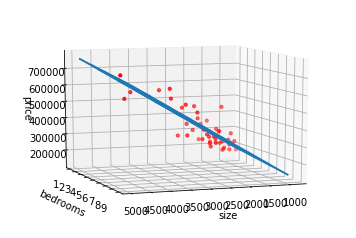

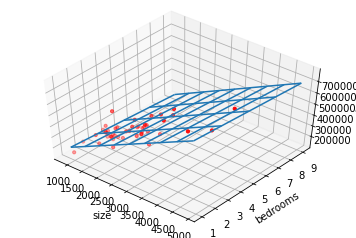

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', elev=10, azim=70)

ax.plot_wireframe(X1, X2, y_pred_grid)

ax.scatter(X[:, 0], X[:, 1], y, color='r', s=10)

ax.set_ylabel('bedrooms')
ax.set_xlabel('size')
ax.set_zlabel('price');
display(fig)
ax.view_init(elev=50, azim=-50)

## Visualize the cost function in 3D

The model prediction is `X @ θ`, where `X` is the normalized training set:

In [31]:
X_norm0.shape

(47, 3)

Instead of a single-point `θ`, we user an array `TT` of points covering 
a rectangualr grid in the parameter space:

In [32]:
θ

array([340412.65957447, 109447.79538813,  -6578.35377265])

In [33]:
θ1 = np.arange(0, 200000, 4000)
θ2 = np.arange(-100000, 100000, 2500)
T1, T2 = np.meshgrid(θ1, θ2)

In [34]:
TT = np.vstack([np.ones(T1.size)*θ[0], T1.ravel(), T2.ravel()])
TT.shape

(3, 4000)

Next, the error for each traning vector and each parameter vector is:

In [35]:
error = (X_norm0 @ TT).T - y
error.shape

(4000, 47)

Finally, we evaluate the cost function on the parameter space grid:

In [36]:
m = len(y)
J = 1 / (2*m) * (error**2).sum(1)
J.shape

(4000,)

With this we can plot both the cost function "surface"
and the trajectory that gradient descent took to reach
minimum.

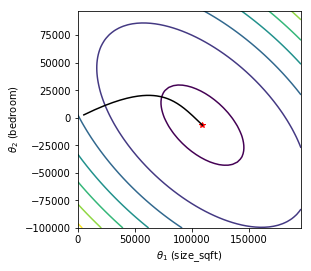

In [37]:
plt.figure(figsize=(4, 4))
plt.contour(θ1, θ2, J.reshape(T1.shape))
plt.plot(θ[1], θ[2], 'r*')
plt.plot(θ_history[:, 1], θ_history[:, 2], 'k');
plt.xlabel(r'$\theta_1$ (size_sqft)'); plt.ylabel(r'$\theta_2$ (bedroom)');

In [38]:
θ0 = θ.copy()

We can play with the learning rate $\alpha$ and see
how the algorithm become faster but tends to be instable
as $\alpha$ increases:

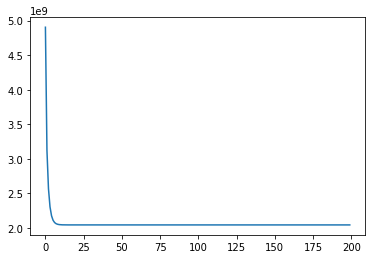

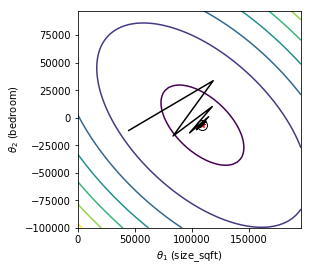

In [39]:
α = 1.1
num_iters = 200

θ = [1, 100000, 100000]
θ, J_history, θ_history = gradientDescent(X_norm0, y, θ, α, num_iters);
plt.plot(J_history);

plt.figure(figsize=(4, 4))
plt.contour(θ1, θ2, J.reshape(T1.shape))
plt.plot(θ[1], θ[2], 'ok', ms=10, mfc='none')
plt.plot(θ0[1], θ0[2], 'r*')
plt.plot(θ_history[:, 1], θ_history[:, 2], 'k');
plt.xlabel(r'$\theta_1$ (size_sqft)'); plt.ylabel(r'$\theta_2$ (bedroom)');

For the fun of it, we can also show the surface in 3D.
It makes a pretty plot even though I don't think it 
adds much in terms of understanding:

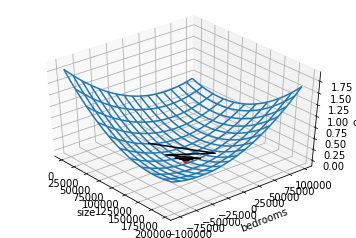

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d', elev=40, azim=-40)

ax.plot_wireframe(T1, T2, J.reshape(T1.shape),
                 cstride=5, rstride=5,
                 #edgecolor='none', linewidth=0,
                 cmap=plt.cm.viridis)

ax.scatter(θ[1], θ[2], color='r', s=20, zorder=10)
ax.plot(θ_history[:, 1], θ_history[:, 2], 'k');
ax.set_ylabel('bedrooms')
ax.set_xlabel('size')
ax.set_zlabel('cost');

# Using the Normal Equation

Recalling the normal equation:

$$\theta = (X^T X)^{-1} X^T y $$

which translates in code to:

In [41]:
def normalEquation(X, y):
    return np.linalg.pinv(X.T @ X) @ X.T @ y

We use the unnormalized training set:

In [42]:
X0 = np.hstack([np.ones((X.shape[0], 1)), X])
θ_ne = normalEquation(X0, y)
θ_ne

array([89597.90954361,   139.21067402, -8738.01911255])

Note that, since the features are not normalized, we cannot compare
the numerical value of `θ_ne` with that of `θ`.

In [43]:
θ / θ_ne

array([3.79933708e+00, 7.86202619e+02, 7.52842809e-01])

In [44]:
σ, 1/σ

(array([7.86202619e+02, 7.52842809e-01]),
 array([1.27193675e-03, 1.32829853e+00]))

In [45]:
θu = θ.copy()
θu[1:] = (θu[1:]/σ)
θu

array([ 3.40412660e+05,  1.39210674e+02, -8.73801911e+03])

The 

In [46]:
df['price_predicted_ne'] = X0 @ θ_ne
df.head()

feature,size_sqft,bedrooms,price,price_predicted,error,price_predicted_ne
sample,,,,,,
0,2104,3,399900,356283.109952,43616.890048,356283.110339
1,1600,3,329900,286120.930941,43779.069059,286120.930634
2,2400,3,369000,397489.469054,-28489.469054,397489.469848
3,1416,2,232000,269244.184850,-37244.184850,269244.185727
4,3000,4,539900,472277.854964,67622.145036,472277.855146


# Predicting new data

We can generate new simulated apartments to see what 
price they have according to the model:

In [47]:
n = 100
X_new = np.ones((n, 3))

# Genenerate random samples, somewhat "similar" to the training set
X_new[:, 1] = np.random.normal(df.size_sqft.mean(), df.size_sqft.std()/10, size=n)
X_new[:, 2] = np.random.randint(low=1, high=60, size=n)

In [48]:
prediction = X_new @ θ

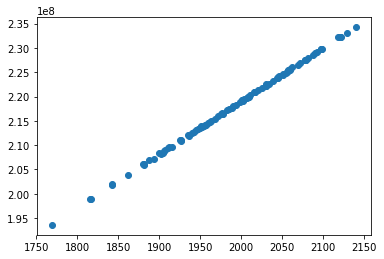

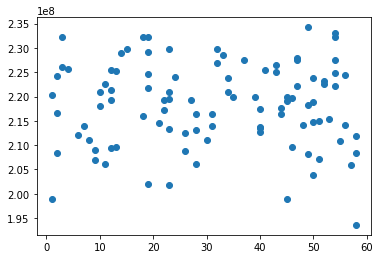

In [49]:
plt.plot(X_new[:, 1], prediction, 'o')
plt.figure()
plt.plot(X_new[:, 2], prediction, 'o')

In [50]:
df.size_sqft.mean(), df.size_sqft.std()

(2000.6808510638298, 794.7023535338897)

# PCA

We have qualitatively seen that one feature (apartment size) 
has much more information than the other (number of bedrooms). 
We can quantify this by decomposing the training set using [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis).

In [76]:
1 / len(y) * (X_norm.T @ X_norm)

array([[1.       , 0.5599672],
       [0.5599672, 1.       ]])

In [113]:
R = np.corrcoef(X, rowvar=False)
R

array([[1.       , 0.5599672],
       [0.5599672, 1.       ]])

In [114]:
C = np.cov(X, rowvar=False)
C

array([[6.31551831e+05, 3.38642461e+02],
       [3.38642461e+02, 5.79093432e-01]])

In [97]:
eigvals, W = np.linalg.eig(C)
order = eigvals.argsort()[::-1]
eigvals = eigvals[order]
W = W[:, order]
W

array([[ 9.99999856e-01, -5.36207178e-04],
       [ 5.36207178e-04,  9.99999856e-01]])

In [103]:
T = (W @ X.T).T
T.shape

(47, 2)

In [104]:
X.shape

(47, 2)

In [109]:
np.cov(X, rowvar=False)

array([[6.31551831e+05, 3.38642461e+02],
       [3.38642461e+02, 5.79093432e-01]])

In [108]:
np.cov(T, rowvar=False)

array([[6.31551286e+05, 6.77284532e+02],
       [6.77284532e+02, 1.12384086e+00]])